In [12]:
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import os
import numpy as np
import warnings
from torch.nn import CrossEntropyLoss
import torch

warnings.filterwarnings("ignore")

In [2]:
RANDOM_PARAMETER = pd.DataFrame(
    [[0.08, 0.32], [0.42, 0.18]], columns=["non-tech", "tech"], index=["stock up", "stock down"]
)
RANDOM_PARAMETER

,non-tech,tech
stock up,0.08,0.32
stock down,0.42,0.18


In [3]:
DATAPOINT_AMOUNT = 100000
STOCK_PRICE_DIFF = 1

# Create a synthetics stock price data

In [4]:
synthetic_data = {
    "date": [1],
    "tech price": [100],
    "is tech price up": [False],
    "non-tech price": [100],
    "is non-tech price up": [False],
}

In [5]:
for date in tqdm(range(DATAPOINT_AMOUNT - 1)):
    synthetic_data["date"].append(date)
    for stock_name in ["tech", "non-tech"]:
        # Decide to go up or not
        is_stock_go_up = random.random() < RANDOM_PARAMETER.loc["stock up", stock_name]
        # Decide how much to go up or down
        diff_price = STOCK_PRICE_DIFF * (1 if is_stock_go_up else -1)
        # Update the price
        new_price = synthetic_data[f"{stock_name} price"][-1] + diff_price
        # Update the data
        synthetic_data[f"{stock_name} price"].append(new_price)
        synthetic_data[f"is {stock_name} price up"].append(is_stock_go_up)

# Convert to DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

100%|██████████| 99999/99999 [00:00<00:00, 138833.75it/s]


In [6]:
# Save stock price
os.makedirs("stock_price_data", exist_ok=True)
file_path = "stock_price_data/synthetic_stock_price_data.csv"
if os.path.exists(file_path):
    files_in_folder = os.listdir("stock_price_data")
    files_in_folder = [file for file in files_in_folder if file.startswith("synthetic_stock_price_data")]
    file_path = f"stock_price_data/synthetic_stock_price_data_{len(files_in_folder)}.csv"
synthetic_df.to_csv(file_path, index=False)

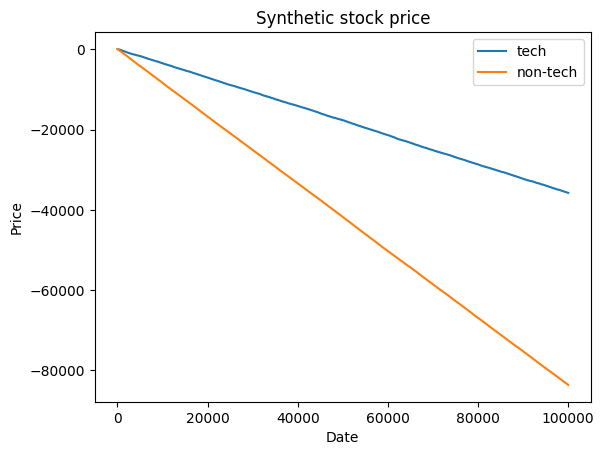

In [7]:
# Plot the stock price
plt.plot(synthetic_df["date"], synthetic_df["tech price"], label="tech")
plt.plot(synthetic_df["date"], synthetic_df["non-tech price"], label="non-tech")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Synthetic stock price")
plt.savefig("stock_price_data/synthetic_stock_price.png")
plt.show()

# Create stock prediction

In [8]:
data_df = pd.read_csv("./stock_price_data/synthetic_stock_price_data.csv", index_col=["date"])
data_df

,tech price,is tech price up,non-tech price,is non-tech price up
date,,,,
1,100,False,100,False
0,101,True,101,True
1,100,False,100,False
2,99,False,99,False
3,98,False,98,False
...,...,...,...,...
99994,-35759,False,-83629,False
99995,-35760,False,-83630,False
99996,-35759,True,-83631,False


In [ ]:
class StockPredictionClassifier:
    def __init__(self) -> None:
        # Our knowledge about the stock market
        self.parameter = RANDOM_PARAMETER.copy()

    def predict(self, stock_name: str, supports: list[bool] | None = None) -> float:
        if supports is None:
            return self.parameter.loc["stock up", stock_name] / (self.parameter.loc[:, stock_name].sum() + 1e-10)
        else:
            # Use bayesian inference to calculate the probability
            # P(y|X) = P(X|y) * P(y) / P(X)

            # Initial prior probabilities P(y) and P(not y)
            total_counts = self.parameter.values.sum() + 1e-10  # Avoid division by zero
            p_y = self.parameter.loc["stock up", stock_name] / total_counts  # P(stock up)
            p_not_y = self.parameter.loc["stock down", stock_name] / total_counts  # P(stock down)

            # Iterate over each support to update the posterior probability
            for support in supports:
                index = "stock up" if support else "stock down"
                not_index = "stock down" if support else "stock up"

                # Likelihoods P(X|y) and P(X|not y)
                p_X_given_y = self.parameter.loc[index, stock_name] / (self.parameter.loc[index, :].sum() + 1e-10)
                p_X_given_not_y = self.parameter.loc[not_index, stock_name] / (
                    self.parameter.loc[not_index, :].sum() + 1e-10
                )

                # Update posterior using Bayes' theorem: P(y|X) = P(X|y) * P(y) / P(X)
                # P(X) = P(X|y) * P(y) + P(X|not y) * P(not y)
                p_x = p_X_given_y * p_y + p_X_given_not_y * p_not_y
                p_y = (p_X_given_y * p_y) / (p_x + 1e-10)  # New P(stock up | X)
                p_not_y = (p_X_given_not_y * p_not_y) / (p_x + 1e-10)  # New P(stock down | X)

            return p_y  # Return the final probability of stock going up

In [10]:
classifier = StockPredictionClassifier()

labels = data_df["is tech price up"].values

In [18]:
result = {"support_amount": [], "acc": [], "entropy": []}

for support_amount in tqdm(range(1, 10)):
    result["support_amount"].append(support_amount)
    predictions = [0] * len(labels)
    for i in range(len(labels)):
        predictions[i] = classifier.predict("tech", labels[max(0, i - support_amount) : i])
    predictions = np.array(predictions)

    # Calculate the accuracy
    acc = (predictions > 0.5) == labels
    acc = acc.mean()
    result["acc"].append(acc)

100%|██████████| 9/9 [03:14<00:00, 21.57s/it]


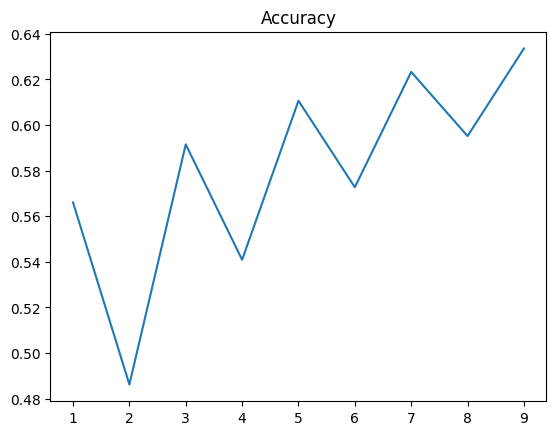

In [20]:
# removve entropy key
result.pop("entropy", None)
result_df = pd.DataFrame(result)

plt.title("Accuracy")
plt.plot(result_df["support_amount"], result_df["acc"], label="Accuracy")